# Direction based residual for a periodic orbit 


In [1]:
import numpy as np
from ipywidgets import interactive
import matplotlib.pyplot as plt
#-------------------------------------
import parameters as p  
import functions as f   
#-------------------------------------

# Forcing wavenumber
n = 4

# Reynolds number
Re = 60

# Time & final time
t = 0.
T = 100.0
q=0

#timestep 
dt = 0.005
#Resolution
Nx = 128
Ny = 128

#Length of domain
Lx = 2*np.pi
Ly = 2*np.pi

#-------------------------------------
#-------------------------------------

# Set everything up in advance, and the initial condition
u = f.init(Nx,Ny,Lx,Ly,n,dt,Re)

#variables used for plotting animation (check this is the best implementation)
iplot = 0

tmax = int(T/dt)
tjump = int(np.ceil(0.1/dt))

sampletime  = tmax//1
sampleincs = sampletime//tjump

unew = np.zeros((Ny,Nx//2+1),dtype=complex)
unew1 = np.zeros((Ny,Nx//2+1),dtype=complex)

nsnaps = 101
nstep = int(np.floor(T/dt))
pstep = int(np.ceil(nstep/(nsnaps)))
uplot = np.zeros((Ny,Nx,nsnaps))

Dis = np.zeros(int(T/dt),dtype=float)
Pow = np.zeros(int(T/dt),dtype=float)
Eng = np.zeros(int(T/dt),dtype=float) 
dlam = Re/(2*(4**2))


f.Structure is a function that unpacks a periodic orbit from the file 'UPOsRe60.out'. Specific orbits can be found by changing the 'irest' parameter within the function. 

In [2]:
myZ = f.Structure(Nx,Ny)[0]
Tend = f.Structure(Nx,Ny)[1]

We then resize dt such that an exact integer multiple of dt fits the period of the orbit. 

In [3]:
dt = 0.005
nsteps = int((Tend)/dt)
dt = (Tend)/nsteps

u = f.init(Nx,Ny,Lx,Ly,n,dt,Re)

subP = int(2.354/dt)

u = myZ

Functions are called to impliment the timestepping. Spatial information is stored at each timestep.

In [4]:
j=1
P=1
tjumpinc = tjump
Store = np.zeros((sampleincs,np.size(unew[:,0]),np.size(unew[0,:])))
Usave = np.zeros(np.shape(unew))
#-----
PlotFlag = 1
#-----

for i in range(sampletime):
    unew = p.cn1*((p.cn2*u) + f.rk4(u)) 
    
    if i == 0:
        Store[0,:,:] = unew[:,:]
    
    if i == tjump:    
        
        Store[P,:,:] = unew[:,:] 
        
        j+=1
        P+=1
        
        tjump = tjump+tjumpinc
    
    
    Dis[i] = f.Diss(unew,Re,OnFlag = 1)  
    Pow[i] = f.Power(unew,n,OnFlag = 1)
    Eng[i] = f.Energy(unew,OnFlag =1)
    
    if i== nsteps:
        Usave = unew
    
    
    if PlotFlag ==1:
        if(int(t/dt) % pstep == 0): # Save for plotting
            uplot[:,:,iplot] = np.fft.irfft2(unew[:,:])*(Nx*Ny) 
            iplot = iplot+1
    else:
        continue
        
    u = unew       
    t = t + dt 

/home/edward/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  
/home/edward/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


We restrict the amplitude of modes that are sampled for the residual. 

In [5]:
Mode = np.ones_like(p.ksq)
Mode1 = np.ones_like(p.ksq)
Mode[np.where(np.sqrt(p.ksq)<=1) ] = 0.
Mode1[np.where(np.sqrt(p.ksq)>5) ] = 0.
Mode = np.where((p.kx==0)&(p.ky==0),0,Mode)
Mode1 = np.where((p.kx==0)&(p.ky==0),0,Mode1)

In [6]:
Vec = np.zeros(((sampleincs,np.size(unew[:,0]),np.size(unew[0,:]))))

for i in range(1,sampleincs):
    Vec[i,:,:] = (Store[i,:,:] - Store[i-1,:,:])*Mode*Mode1


This function calculates the complex dot product of the two vectors needed for the residual.

In [7]:
def angl(nt, dT):
    
    A = Vec[nt,:,:]
    B = Vec[nt - dT ,:,:]
    
    up = np.sum(((A)*np.conj(B)).real)
    down = ((np.linalg.norm(A))*(np.linalg.norm(B)))
    
    cosangl = up/down
    
    return cosangl 

In [8]:
nt = np.arange(0,sampleincs,1,dtype=int)
dT = np.arange(0,sampleincs,1,dtype=int)

X, Y = np.meshgrid(nt, dT)

zdata = np.zeros(np.shape(X))

for i in range(1,sampleincs-1):
    for j in range(1,(sampleincs)-1):
        if i-j>0 and j<sampleincs//(2*T//100):
            zdata[i,j] = angl(i,j)

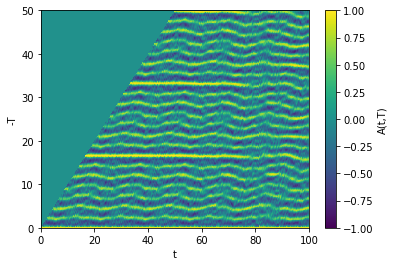

In [9]:
f.UPOplot(Y,X,zdata,SaveFlag = 1)

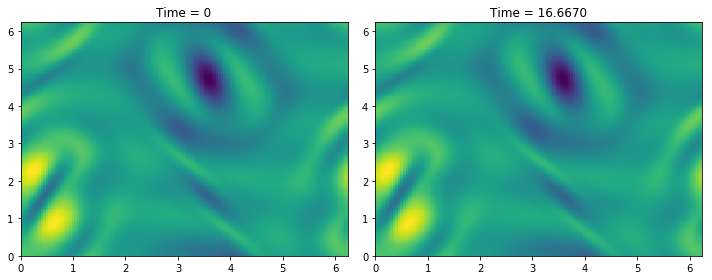

In [10]:
x = np.linspace(0,Lx-p.dx,Nx)
y = np.linspace(0,Ly-p.dy,Ny)
[xx,yy] = np.meshgrid(x,y)

fig = plt.figure(figsize=(10,4))  
ax1 = fig.add_subplot(121)        
#------------------------------------------------------------
ax1.pcolor(xx,yy,np.fft.irfft2(myZ[:,:])*(Nx*Ny))          
ax1.set_xlabel("") 
ax1.set_ylabel("")
ax1.set_title('Time = 0')
#------------------------------------------------------------
ax2 = fig.add_subplot(122) 
#------------------------------------------------------------
ax2.pcolor(xx,yy,np.fft.irfft2(Usave[:,:])*(Nx*Ny))           
ax2.set_xlabel('') 
ax2.set_ylabel('')
ax2.set_ylim()
ax2.set_xlim()
ax2.set_title('Time = {:.4f}'.format(Tend))
#------------------------------------------------------------
fig.tight_layout()
plt.show()

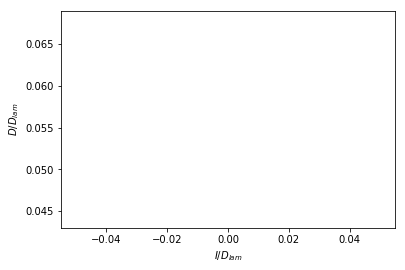

0.0


In [11]:
for i in range(0,1):
    plt.plot(Pow[0:i*subP]/dlam,Dis[0:i*subP]/dlam,'g')            
    plt.xlabel("$I/D_{lam}$") 
    plt.ylabel('$D/D_{lam}$')
    plt.ylim(0.043,0.069)
    plt.xlim()
    plt.title("")
    plt.show()
    print(i*subP*dt)

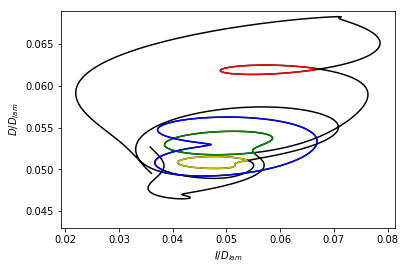

In [74]:
plt.plot(Pow[0:nsteps]/dlam,Dis[0:nsteps]/dlam,'k')
plt.plot(Pow[int(1.259*subP):int(2.02*subP)]/dlam,Dis[int(1.259*subP):int(2.02*subP)]/dlam,'g') 
plt.plot(Pow[int(2.5*subP):int(2.8599*subP)]/dlam,Dis[int(2.5*subP):int(2.8599*subP)]/dlam,'r') 
plt.plot(Pow[int(4.09*subP):int(5.241*subP)]/dlam,Dis[int(4.09*subP):int(5.241*subP)]/dlam,'b') 
plt.plot(Pow[int(5.71*subP):int(6.35*subP)]/dlam,Dis[int(5.71*subP):int(6.35*subP)]/dlam,'y')
plt.xlabel("$I/D_{lam}$") 
plt.ylabel('$D/D_{lam}$')
plt.ylim(0.043,0.069)
plt.xlim()
plt.title("")
plt.savefig('subp.png')
plt.show()


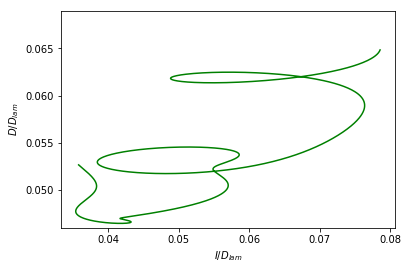

In [13]:
plt.plot(Pow[0:3*subP]/dlam,Dis[0:3*subP]/dlam,'g')            
plt.xlabel("$I/D_{lam}$") 
plt.ylabel('$D/D_{lam}$')
plt.ylim(0.046,0.069)
plt.xlim()
plt.title("")
plt.savefig('orb4.png')
plt.show()

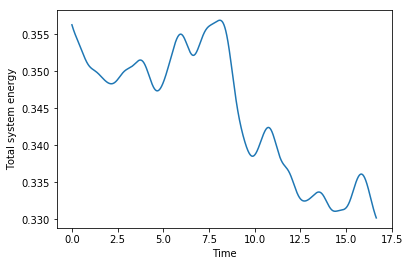

In [14]:
TTT = np.arange(0,nsteps,1)

plt.plot(TTT*dt,Eng[0:nsteps]/dlam)
plt.xlabel('Time')
plt.ylabel('Total system energy')
plt.savefig('Energydist.png')
plt.show()


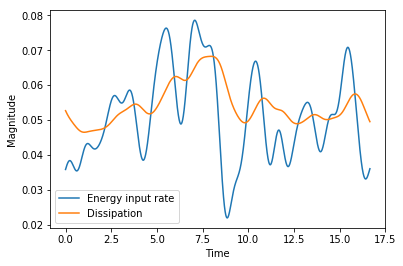

In [15]:
plt.plot(TTT*dt,Pow[0:nsteps]/dlam , label = 'Energy input rate')
plt.plot(TTT*dt,Dis[0:nsteps]/dlam, label = 'Dissipation')
#plt.axhline(y = 0.053)
#plt.plot(TTT*dt,Eng[0:nsteps]/dlam)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.savefig('Energydist.png')
plt.show()

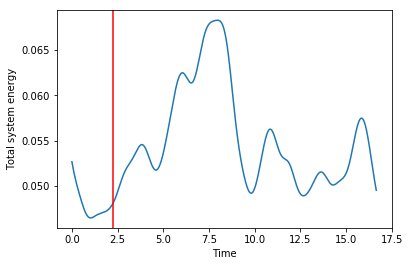

In [16]:
plt.plot(TTT*dt,Dis[0:nsteps]/dlam)
plt.axvline(x=2.254,color='r')
plt.xlabel('Time')
plt.ylabel('Total system energy')
plt.savefig('Energydist.png')
plt.show()